# Topic modelling on news messages

## Business Understanding
* Objective: Analyze the content of the news articles on Apple.             
* Scope: all articles with Apple in the title.all articles with Apple in the title.
* Dataset: Data from https://www.kaggle.com/datasets/gennadiyr/us-equities-news-data?resource=download, which has already been preprocessed to remove punctuation
    * Scope: Apple stock (AAPL) related news 
* Key model:
    * Topic Modelling: LDA

1. Topic modeling algorithm Evaluation and Selection

Four different topic modelling algorithms were tested and evaluated according to the coherence score. These models were Latent Dirichlet Allocation (LDA), Non-Negative Matrix Factorization (NMF), Fuzzy Latent Semantic Analysis (FLSA),Latent Semantic Indexing (LSI). This measure was chosen as it has high human interpretability. In particular, (Röder M. et al., 2015) defends Cv as the best performing coherence measure. It is calculated by combining the indirect cosine measure with the NPMI and the boolean sliding window. The best topic cohesion across three to seven topics were the following for the four models:

1. LdaMulticore<num_terms=23892, num_topics=7, decay=0.5, chunksize=2000> with 0.457 coherence
2. <gensim.models.nmf.Nmf object at 0x000001DAACAF5360> with 0.454 coherence
3. <FuzzyTM.FuzzyTM.FLSA_W object at 0x000001DA79CB7EE0> with 0.439 coherence
4. LsiModel<num_terms=23892, num_topics=4, decay=1.0, chunksize=20000> with 0.394 coherence

The model with highest coherence was LdaMulticore with 0.457 coherence. This model was hypertuned on alpha and beta by iterations on the optimal amount of topics and resulted in 0.48470 topic coherence. The best result was the following configuration: LdaMulticore<num_terms=23892, num_topics=7, decay=0.5, chunksize=2000>, alpha = 0.01 and beta =	0.75.

The final model chosen, LDA, discovers topics that are hidden (latent) in a set of text documents by inferring possible topics based on their words. It uses a generative probabilistic model (generating data that is similar to observed previous data) and Dirichlet distributions (basically a distribution over distributions) to achieve this. The inference in LDA is based on a Bayesian framework. This allows the model to infer topics based on observed data (words) through the use of conditional probabilities. This model works with as a Bag of words model. One Matrix contains the n topics as each row and each column represents a word (or ngram) and the values are the probabilities that that words belong to the topic. Another matrix is the bag of Words of all words (columns) present for each document (row). These are multiplied to obtain the conditional probability that the word takes on each topic. This way it is possible to obtain which topic is most probably to each document.


2. Choice of number of topics

As the corpus is limited to Apple stock (AAPL) related news, the objective here is to understand what are the main topics that are published about Apple financially. Furthermore, since it is already quite a narrow subject, that is, only relating to finantial news of a single company, it would make no sense to have too many topics, as many of these would have similar words. Thus, the optimal amount of topics of seven was obtained by calculating the coherence score in the limited range from three to seven. To confirm that this amount of topic is good for the the corpus tests, a visualization with LDAvis is presented to show that the topics do not have a large overlap, such as a subtopic within a greater topic. 

Although the topics seem very repetitive given that it is a very narrow subject, an overview in time shows what is the trend over the years. That is, what topics have become more relevant over time. 


3. Corpus quality

As most of the text comes from news articles almost no typos were found at eyeballing. Some preprocessing has already been done such as removing puctuation. Unfortunately, this was roughly performed as some words such as U.S. turned into U S which is meaningless. Other words such as ReleaseChicago were clumped together, so they needed to be separated. To improve the input of the topic modelling, bigrams, trigrams and quadrigrams were created, but resulted in lower coherence. The results for this are in a different notebook, being the best model FuzzyTM.FuzzyTM.FLSA_W with 0.385 coherence.

To evaluate topics qualitatively several iterations were made, removing some words that are not so informative in this dataset. For example, 'apple' is not an informative words, since all news are about the company. However, in the other analysis with ngrams, it was interesting to see combination with 'apple-watch', 'phone' and 'samsung' together as the news relating to just the phone and accessories parts fof the business. Nonetheless, words that are too frequent can be eliminated without losing any information as they don’t add any specific information which would make the document stand out.


4. Results

The topics found were:
0.	zacks stock investment research market security year nasdaq buy rank recommendation analyst perf...	0.63057
1.	apple said aapl phone court case tax government data one time commission day back week	0.39892
2.	apple year earnings stock quarter revenue billion share estimate growth phone market sale invest...	0.45311
3.	apple said reuters tax inc china company technology year one new billion nasdaq state trump	0.33229
4.	apple percent nasdaq stock share market year nyse index said phone inc week china dow	0.41907
5.	apple phone service new analyst year nasdaq market sale streaming price zacks music device share	0.38796


5. Limitations

A few limitations of LDA need to be taken into consideration:
1. LDA is unable to depict correlations which led to occurrence of uncorrelated topics.
2. As a Bag of words model, order of the words, grammatical role of the words, and sentence structure are not considered in the model.
3. LDA is Unsupervised (sometimes weak supervision is desirable, e.g. in sentiment analysis)
4. The number of topics need to be set manually, which was optimized by iterating over each amount in the designed range.


6. Topic Modelling application in finantial companies

Topic modelling wise, it would have been interesting to gather news from multiple sources to understand the trends of topics about the company in a broader themes to give context to the finantial situation of the company. This way further analysis considering this bigger picture could possibly explain the performance of the company in context. When linked to finantial data of stocks in time, such as with the previous project, it could clarify the source of the increase in value of stocks. In other words, whether an increase came solely because of the launch of a feature for because inflation went down. Also which combination of topics were trending when the stocks go up or when the stocks go down. This way it would be easier to predict what kind of topics influenciate the value of stocks the most.


Matoba-Camila-2067717.pdf
Matoba-Camila-2067717.zip

In [1]:
num_topics = 5
num_words = 20

# For consistency
seed = 42
# Output folder
out_dir = 'model_output'

### Imports

In [2]:
import pandas as pd
pd.options.display.max_colwidth = 100 # To see text better
pd.set_option('display.precision', 5)
import numpy as np
import re #regex

import scipy
from scipy.stats import randint, uniform
from functools import partial
import collections
from collections import defaultdict
import os

import pickle
import joblib
from tqdm import tqdm
import datetime
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {'figure.figsize':(12,6), "axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Topic Modelling imports
import gensim
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import similarities
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

from FuzzyTM import FLSA_W

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF

# Visualisation
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# NLTK imports
import nltk
import nltk.corpus
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt') # for the tokenizer
#nltk.download('averaged_perceptron_tagger') # for POS
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.tokenize import RegexpTokenizer

# Create the output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

D:\Users\camil\anaconda3\envs\pytorch_venv\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [3]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
import spacy
#conda install -c conda-forge spacy-model-en_core_web_lg
nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])

D:\Users\camil\anaconda3\envs\pytorch_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Understanding
### Feature engineering
As the scope is only articles with appl. in the title, there are only 2909 articles. The attribute bring worked on is only 'content'
For that reason:
* There are no missing values, so no need for imputation (e.g. df = df.fillna(0))
* There is no collinearity (attributes with the same information)
* No outlier was considered 

In [5]:
# News data
#data1 = pd.read_csv('analyst_ratings_processed.csv', index_col=0)
#data1.dropna(inplace = True)
#data1.rename(columns={'stock':'ticker'}, inplace=True)
#data1['date'] = data1['date'].apply(lambda x : x.split()[0])
data_df = pd.read_csv('us_equities_news_dataset.csv', index_col=0)
data_df.dropna(inplace = True)
data_df.reset_index(drop=True, inplace=True)
data_df.rename(columns={'release_date':'date'}, inplace=True)
data_df.drop(inplace=True, columns=['category', 'url', 'article_id'], axis=1)

#data = pd.concat([data1, data2])
data = data_df
data.drop_duplicates(subset='title', keep='first', inplace=True)

# Only articles that contain Apple in the title
data = data_df.loc[data_df['title'].str.contains(pat = r'\sappl.?\b', flags=re.IGNORECASE, regex = True)]

In [6]:
# Looking at the data
print(data.info()) # Cleaned, with no null objects
#start_date = data['date'].min()
#end_date = data['date'].max()
#print(f"\nMin date: {start_date}\nMax date: {end_date}")
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2909 entries, 57 to 217740
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ticker    2909 non-null   object
 1   title     2909 non-null   object
 2   content   2909 non-null   object
 3   date      2909 non-null   object
 4   provider  2909 non-null   object
dtypes: object(5)
memory usage: 136.4+ KB
None


,ticker,title,content,date,provider
57,NIO,Stocks Dow Drops Nearly 400 Points as Apple Leads Tech Rout,Investing com A rout in Apple and Facebook NASDAQ FB Monday swept through tech prompting a ...,2018-11-19,Investing.com
110,UBER,Tempur Sealy Fiat Chrysler Automobiles Spotify Apple And Amazon Highlighted As Zacks Bull And...,For Immediate ReleaseChicago IL January 9 2020 Shares of Tempur Sealy NYSE TPX as the...,2020-01-08,Zacks Investment Research
131,UBER,The Zacks Analyst Blog Highlights Amazon Microsoft Apple Netflix And Facebook,For Immediate ReleaseChicago IL December 30 2019 Zacks com announces the list of stocks fe...,2019-12-29,Zacks Investment Research
152,UBER,The Zacks Analyst Blog Highlights Apple Spotify Netflix Disney And Comcast,For Immediate ReleaseChicago IL December 18 2019 Zacks com announces the list of stocks fe...,2019-12-17,Zacks Investment Research
196,UBER,NVIDIA Greenbrier Uber Amazon And Apple Highlighted As Zacks Bull And Bear Of The Day,For Immediate ReleaseChicago IL November 26 2019 NVIDIA NASDAQ NVDA as the Bull of th...,2019-11-25,Zacks Investment Research


## Data Preparation

In [7]:
stop_words = stopwords.words('english')
stop_words.extend(['see', 'say', 'also', 'company', 'would', 'could', 'make', 'use']) #, 'apple', 'aapl'
keep_list = []#['no', 'not'] 
for word in keep_list:
    try:
        stop_words.remove(word)
    except:
        pass

# Checking if there are still words in the list:
#any(item in keep_list for item in stop_words)

def clean_text(text, normalize = True, remove_stopwords = True, stop_words = stop_words, 
               tokenize = False, lemmatizer = WordNetLemmatizer()):
    '''
    Return text, with the options:
    Normalization, Removal of unwanted characters, stopwords
    Attenttion: Lemmatizer needs tokenizer
    '''
    # Separate words capitalized together eg. NewsToday -> News Today
    text = re.sub( r"([A-Z]+[a-zA-Z])", r" \1", text)
    
    if normalize: # Convert words to lower case
        text = text.lower()
    
    # Tabs
    text = re.sub(r"[\n][\t]*|[\t]", " ", text) 
    # Puctuation
    #text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', '', text)
    # Numbers
    text = re.sub(r"[0-9]", "",text)
    # too long words: Incomprehensibilities is longest word “in common usage" or single letters
    text = re.sub(r"\b\w{25,90}\b|\b\w{1}\b", "",text)
    # Removing mentions (@person) and Hashtags #topic, 
    #text = re.sub(r"(@|#\ z0-9]+)|([^0-9A-Za-z \t])|^rt", "", text)
    # HTML
    #text = re.sub(r"(\<a href)|(<br />)", "", text)
    # Links: http://
    #text = re.sub(r"https?:\/\/.*[\r\n]*", "", text, flags=re.MULTILINE)    
    
       
    # Tokenizer    
    tokens = nltk.word_tokenize(text)

    if remove_stopwords:
        tokens = [word for word in tokens if word not in (stop_words)]

    if lemmatizer != False: # Lemmatization
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
            
    if tokenize:
        return tokens
    
    else:
        text = " ".join([word for word in tokens])
        # Extra space
        text = re.sub(r"\s+"," ",text)
        return text

corpus = data['content'].apply(lambda x: clean_text(x))
corpus.reset_index(drop = True, inplace = True)
# Tokenizing
corpus_tokenized = corpus.apply(lambda x: re.compile(r'\w+').findall(x))

In [4]:
#!pip install clean-text
# from cleantext.sklearn import CleanTransformer
# cleaner = CleanTransformer(no_punct=False, lower=False)
# cleaner.transform(corpus)

In [8]:
def lemmatization(corpus_tokenized, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    corpus_lemmatized = []
    for sent in corpus_tokenized:
        doc = nlp(" ".join(sent))
        if allowed_postags:
            corpus_lemmatized.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        else:
            corpus_lemmatized.append([token.lemma_ for token in doc])
    return corpus_lemmatized

# Do lemmatization keeping only noun, adj, vb, adv
corpus_lemmatized = lemmatization(corpus_tokenized, allowed_postags=False)

print(corpus_lemmatized[:1][0][:30])

['invest', 'com', 'rout', 'apple', 'facebook', 'nasdaq', 'fb', 'monday', 'sweep', 'tech', 'prompt', 'wave', 'selling', 'across', 'broad', 'market', 'dow', 'jones', 'industrial', 'average', 'fall', 'fall', 'nasdaq', 'composite', 'fall', 'sentiment', 'sour', 'faang', 'stock', 'investor']


In [9]:
def prepare_corpus(corpus_tokenized):
    """
    Input  : Preprocessed documents
    Purpose: Create term dictionary from the corpus and convert list of documents (corpus) into document term matrix
    Output : Term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index.
    dictionary = corpora.Dictionary(corpus_tokenized)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus_tokenized]

    return dictionary, doc_term_matrix

dictionary, doc_term_matrix = prepare_corpus(corpus_tokenized)
print(f"Len dictionary: {len(dictionary)}\n")
dictionary.most_common(30)

Len dictionary: 23892



[('apple', 21121),
 ('stock', 10192),
 ('year', 8938),
 ('phone', 7826),
 ('market', 7250),
 ('zacks', 6941),
 ('nasdaq', 6703),
 ('share', 5995),
 ('earnings', 5303),
 ('billion', 4835),
 ('said', 4801),
 ('quarter', 4544),
 ('new', 4472),
 ('investment', 4462),
 ('revenue', 4208),
 ('analyst', 3984),
 ('aapl', 3890),
 ('sale', 3648),
 ('investor', 3611),
 ('price', 3567),
 ('growth', 3508),
 ('service', 3327),
 ('inc', 3269),
 ('nyse', 3211),
 ('last', 3210),
 ('time', 3020),
 ('report', 2923),
 ('estimate', 2875),
 ('percent', 2868),
 ('research', 2768)]

### Making ngrams
https://radimrehurek.com/gensim/models/phrases.html

def make_ngrams(corpus_tokenized = corpus_tokenized, n = 4, min_count = 5, threshold = 0.25, scoring=  'npmi'): #'default'
    # higher threshold fewer phrases
    bigram = gensim.models.Phrases(corpus_tokenized, min_count=min_count, threshold=threshold, 
                                   connector_words=ENGLISH_CONNECTOR_WORDS, scoring=scoring) #max_vocab_size 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    if n == 2:
        bigram.save('{}/ngram.pkl'.format(out_dir))
        return bigram, [bigram_mod[doc] for doc in corpus_tokenized]
    
    trigram = gensim.models.Phrases(bigram[corpus_tokenized], threshold=threshold,
                                    connector_words=ENGLISH_CONNECTOR_WORDS, scoring=scoring)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    if n == 3:
        trigram.save('{}/ngram.pkl'.format(out_dir))
        return trigram, [trigram_mod[bigram_mod[doc]] for doc in corpus_tokenized]
    
    quadrigram = gensim.models.Phrases(trigram[bigram[corpus_tokenized]], threshold=threshold,
                                       connector_words=ENGLISH_CONNECTOR_WORDS, scoring=scoring)
    quadrigram_mod = gensim.models.phrases.Phraser(quadrigram)
    if n == 4:
        quadrigram.save('{}/ngram.pkl'.format(out_dir))
        return quadrigram, [quadrigram_mod[trigram_mod[bigram_mod[doc]]] for doc in corpus_tokenized]
    
    else:
        print("Choose n in [2,4]")

#try:
    #dictionary = corpora.Dictionary.load_from_text('{}/dictionary'.format(out_dir))
##except:
    #try:
    #    ngram = joblib.load('{}/ngram.pkl'.format(out_dir))
    #    corpus_ngram = [ngram[doc] for doc in corpus_lemmatized]
    #except:
ngram, corpus_ngram = make_ngrams(corpus_lemmatized)

dictionary, doc_term_matrix = prepare_corpus(corpus_ngram)
dictionary.save_as_text('{}/dictionary'.format(out_dir))
print(f"Length of the dictionary: {len(dictionary)}")

frequency = pd.DataFrame.from_dict(ngram.find_phrases(corpus_lemmatized), orient='index', columns = ['score']).sort_values(by='score', ascending=False).reset_index()
print(dictionary.most_common(30))
frequency.head(20)

In [10]:
corpus_ngram = corpus_lemmatized

## Modelling

In [11]:
def create_lsa_model(num_topics = num_topics, dictionary = dictionary, doc_term_matrix = doc_term_matrix,  
                     num_words = num_words, display = False):
    """
    Input  : Preprocessed document, number of topics and number of words associated with each topic
    Purpose: Create LSA model using gensim
    Output : Return LSA model
    """
    # Train model
    model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)
    
    if display:
        topic_words = model.print_topics(num_topics=num_topics, num_words=num_words)
        for i,topic in enumerate(topic_words):
            print('Topic ' , i , ':', re.findall(r'"(.*?)"', topic[1]))
    return model

lsa_model = create_lsa_model(num_topics, dictionary, doc_term_matrix, num_words, display = True)

Topic  0 : ['apple', 'stock', 'year', 'zacks', 'market', 'phone', 'share', 'earnings', 'billion', 'quarter', 'investment', 'revenue', 'nasdaq', 'growth', 'analyst']
Topic  1 : ['apple', 'zacks', 'phone', 'stock', 'investment', 'earnings', 'said', 'research', 'estimate', 'market', 'rank', 'quarter', 'index', 'security', 'recommendation']
Topic  2 : ['billion', 'revenue', 'share', 'zacks', 'investment', 'percent', 'quarter', 'cent', 'year', 'apple', 'expected', 'ago', 'research', 'eps', 'compared']
Topic  3 : ['earnings', 'stock', 'estimate', 'percent', 'quarter', 'market', 'year', 'zacks', 'growth', 'revenue', 'said', 'nasdaq', 'share', 'phone', 'consensus']
Topic  4 : ['earnings', 'zacks', 'billion', 'price', 'week', 'index', 'percent', 'investment', 'service', 'research', 'revenue', 'rate', 'value', 'last', 'day']


In [12]:
def create_lda_model(num_topics = num_topics, dictionary = dictionary, doc_term_matrix = doc_term_matrix,  
                     num_words = num_words, display = False):
    """
    Input  : Preprocessed document, number of topics and number of words associated with each topic
    Purpose: Create LDA model using gensim
    Output : Return LDA model
    """
    # Train model
    model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary, 
                        passes = 10, update_every = 1, chunksize = 10, alpha = 'auto')  
    
    if display:
        topic_words = model.print_topics(num_topics=num_topics, num_words=num_words)
        for i,topic in enumerate(topic_words):
            print('Topic ' , i , ':', re.findall(r'"(.*?)"', topic[1]))
    return model

lda_model = create_lda_model(num_topics, dictionary, doc_term_matrix, num_words, display = True)

Topic  0 : ['zacks', 'stock', 'investment', 'research', 'market', 'security', 'rank', 'buy', 'performance', 'recommendation', 'company', 'information', 'growth', 'analyst', 'return']
Topic  1 : ['percent', 'said', 'index', 'inc', 'market', 'nasdaq', 'bank', 'dow', 'rate', 'rose', 'future', 'nyse', 'fell', 'china', 'data']
Topic  2 : ['apple', 'year', 'share', 'billion', 'revenue', 'quarter', 'earnings', 'sale', 'analyst', 'phone', 'expected', 'growth', 'market', 'report', 'estimate']
Topic  3 : ['stock', 'price', 'market', 'aapl', 'apple', 'day', 'trading', 'investor', 'share', 'time', 'value', 'long', 'level', 'week', 'high']
Topic  4 : ['apple', 'phone', 'new', 'said', 'google', 'product', 'watch', 'technology', 'samsung', 'device', 'like', 'one', 'inc', 'service', 'based']


### Fuzzy model

In [13]:
# Initialize model
flsaW = FLSA_W(input_file = corpus_ngram, num_topics = num_topics, num_words = num_words, 
               word_weighting ='normal', cluster_method = 'fcm',)

# Train topic model and obtain to matrices
pwgt, ptgd = flsaW.get_matrices()

# Get topics
topics = flsaW.show_topics(representation='words')
for id, tp in enumerate(topics):
    print('Topic ' , id, ':', tp)

Topic  0 : ['say', 'rosenblatt', 'accord', 'premarket', 'kuo', 'unnamed', 'kgi', 'escrow', 'paschal', 'chi', 'taiwanese', 'ming', 'nomura', 'midday', 'one']
Topic  1 : ['work', 'people', 'former', 'employee', 'valley', 'silicon', 'workforce', 'suddenly', 'working', 'campus', 'accord', 'staff', 'avenue', 'several', 'recruit']
Topic  2 : ['gmt', 'sept', 'outnumber', 'dji', 'et', 'thomson', 'filing', 'nellis', 'otc', 'taiwan', 'chipmaker', 'spx', 'gainer', 'rose', 'stephen']
Topic  3 : ['aapl', 'phone', 'nasdaq', 'inc', 'first', 'apple', 'new', 'sale', 'trade', 'share', 'still', 'product', 'big', 'week', 'nyse']
Topic  4 : ['reuters', 'york', 'percent', 'comment', 'rival', 'federal', 'jones', 'k', 'cook', 'tim', 'executive', 'european', 'composite', 'chip', 'forecast']


## Evaluation
Several common measures can be optimized, such as predictive likelihood, perplexity, and coherence. Much literature has indicated that maximizing coherence, particularly a measure named Cv (https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

Topic Coherence Metric assesses is how well a topic is ‘supported’ by a text set. Röder, M. et al in Exploring the Space of Topic Coherence Measures proposes a general structure a topic coherence metric follows:
1. Segmentation:  S-one-one,  S-one-all, 
2. Probability Calculation:
* Pbd (bd stands for boolean document) calculate P(w) as the number of documents that word w occurs divided by the total number of documents and P(w1 and w2) as the number of documents that both words occurs divided by the total.
* Pbs (bs stands for boolean sentence), which does the same as the previous method but it considers the occurrences in the sentences, not in the full documents. Another example is Psw (sw stands for sliding window), which considers the occurrences in a sliding window over the texts.
3. Confirmation Measure: in/direct, such as similarity (for example, cosine similarity)
4. Aggregation: arithmetic mean, the median, the geometric mean of the confirmation measures

Measures:
* C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
* C_p is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
* C_uci measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
* C_umass is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
* C_npmi is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
* C_a is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

In [15]:
#Evaluation for the Fuzzy model
coherence = flsaW.get_coherence_score(input_file = corpus_ngram, topics = topics)

diversity = flsaW.get_diversity_score(topics = topics)

interpretability = flsaW.get_interpretability_score(input_file = corpus_ngram, topics = topics)

print('Coherence score: ', str(coherence),
      'Diversity score:', str(diversity),
      'Interpretability score: ', str(interpretability),
      sep = '\n')

Coherence score: 
0.44369403949138986
Diversity score:
0.9866666666666667
Interpretability score: 
0.437778118964838


Best coherence at <FuzzyTM.FuzzyTM.FLSA_W object at 0x000001DA79CB7EE0> with 0.439 coherence



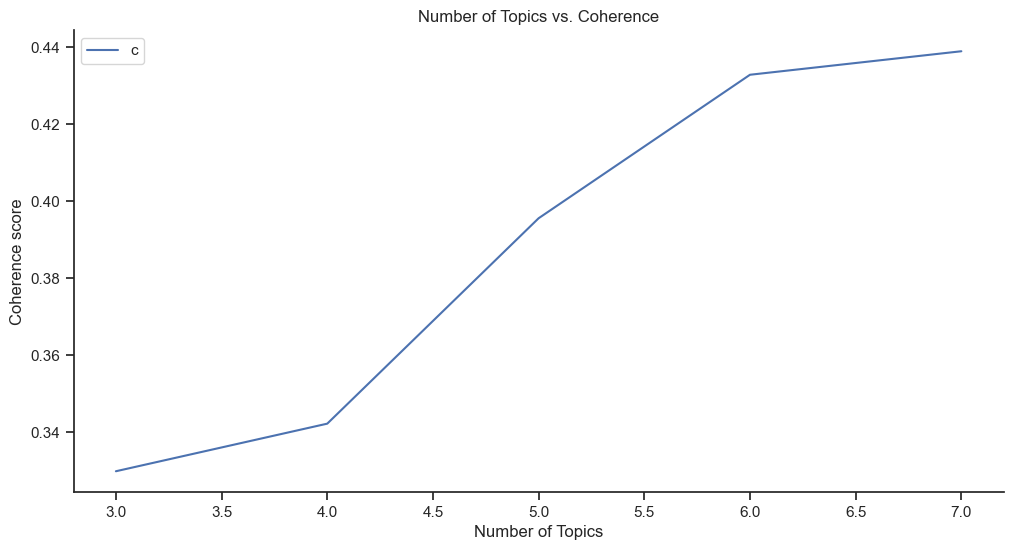

In [16]:
def flsaW_coherence_values(doc_term_matrix = doc_term_matrix, dictionary = dictionary, corpus_ngram = corpus_ngram,
                             num_words = 30, stop = 8, seed = seed):
    """
    Input   : dictionary : A Gensim dictionary
            docume : Gensim corpus
            texts : List of input texts
            stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
            coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for k in range(3, stop):
        model_name = 'FLSA_W'
        model = FLSA_W(input_file = corpus_ngram, num_topics = k, num_words = num_words, 
                       word_weighting ='normal', cluster_method = 'fcm',)

        pwgt, ptgd = model.get_matrices()
        model_list.append(model)
        topics = model.show_topics(representation='words')
        
        coherencemodel = CoherenceModel(topics=topics, texts=corpus_ngram, dictionary=dictionary,
                                        coherence='c_v') #, corpus = doc_term_matrix,  'c_v'
        #coherencemodel = CoherenceModel(model=model, texts=corpus_tokenized, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    coherence_df = pd.DataFrame(list(zip(model_list,coherence_values)), columns=['model','coherence']).sort_values(by = 'coherence', ascending = False)
    model = coherence_df.iloc[0]['model']
    print(f"Best coherence at {coherence_df.iloc[0]['model']} with {coherence_df.iloc[0]['coherence']:.3f} coherence\n")
    
    # Graph
    plt.plot(range(3, stop), coherence_values)
    plt.title('Number of Topics vs. Coherence')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.savefig('{}/{}_coherence.pdf'.format(out_dir, model_name), dpi=300)
    plt.show()
  
    return model, coherence_df

flsaW_model, flsaW_coherence_df = flsaW_coherence_values()

In [14]:
def compute_coherence_values(tm = 'lsa', doc_term_matrix = doc_term_matrix, dictionary = dictionary, corpus_tokenized = corpus_ngram,
                             num_words = 30, stop = 8, seed = seed):
    """
    Input   : dictionary : A Gensim dictionary
            docume : Gensim corpus
            texts : List of input texts
            stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
            coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for k in range(3, stop):
        if tm == 'lsa': #Latent Semantic Analysis
            model = LsiModel(doc_term_matrix, num_topics = k, id2word = dictionary)
            
        elif tm =='nmf':
            model = Nmf(corpus=doc_term_matrix, num_topics = k, id2word = dictionary,
                        passes = 20, chunksize = 5000, eval_every = None, random_state = seed,
                        kappa=.1, minimum_probability=0.01, normalize=True,
                        w_max_iter=200, w_stop_condition=0.0001, h_max_iter=200, h_stop_condition=0.001
                       )
        else:
            model = LdaMulticore(doc_term_matrix, num_topics = k, id2word = dictionary,
                                 passes = 20, iterations = 200, chunksize = 5000, eval_every = None, random_state = seed)
            

        model_list.append(model)
        
        topics = []
        topics_raw = model.show_topics(num_words = num_words, formatted = False)
        for k, content in topics_raw:
            topics.append(list(dict(content).keys()))
        
        coherencemodel = CoherenceModel(topics=topics, texts=corpus_tokenized, dictionary=dictionary,
                                        coherence='c_v') #, corpus = doc_term_matrix,  'c_v'
        #coherencemodel = CoherenceModel(model=model, texts=corpus_tokenized, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    coherence_df = pd.DataFrame(list(zip(model_list,coherence_values)), columns=['model','coherence']).sort_values(by = 'coherence', ascending = False)
    model = coherence_df.iloc[0]['model']
    print(f"Best coherence at {coherence_df.iloc[0]['model']} with {coherence_df.iloc[0]['coherence']:.3f} coherence\n")
    
    # Graph
    plt.plot(range(3, stop), coherence_values)
    plt.title('Number of Topics vs. Coherence')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.savefig('{}/{}_coherence.pdf'.format(out_dir, tm), dpi=300)
    plt.show()
  
    return model, coherence_df

#model, coherence_df = compute_coherence_values(tm = 'lda')

Best coherence at LsiModel<num_terms=23892, num_topics=4, decay=1.0, chunksize=20000> with 0.394 coherence



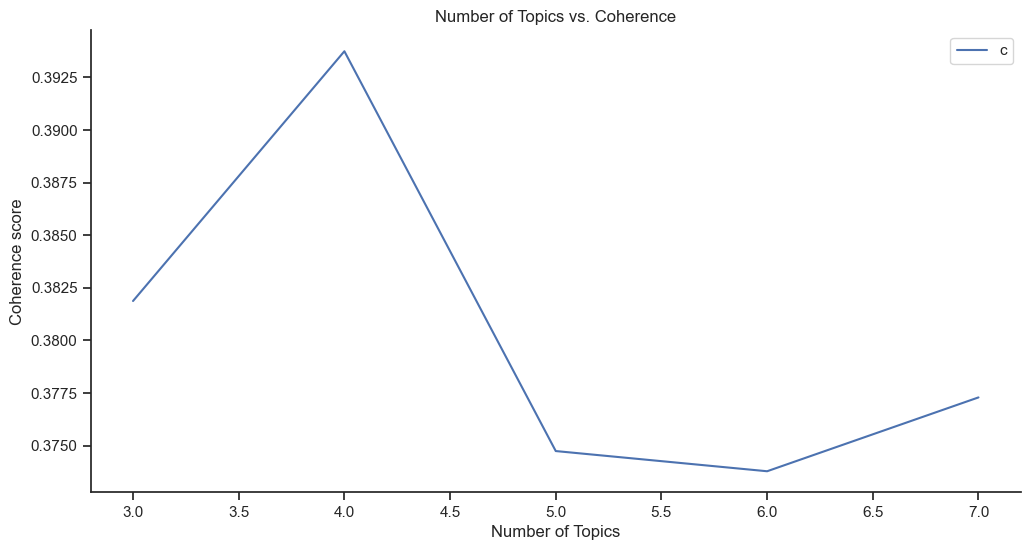

In [17]:
model_lsa, coherence_df_lsa = compute_coherence_values(tm = 'lsa')

D:\Users\camil\anaconda3\envs\pytorch_venv\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Users\camil\anaconda3\envs\pytorch_venv\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


Best coherence at <gensim.models.nmf.Nmf object at 0x000001DAACAF5360> with 0.454 coherence



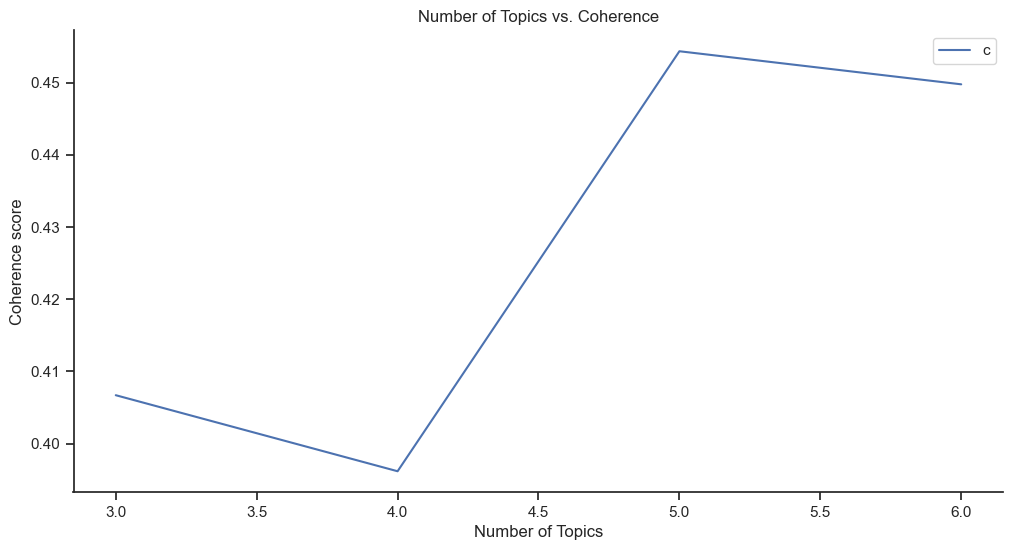

In [18]:
model_nmf, coherence_df_nmf = compute_coherence_values(tm = 'nmf')

Best coherence at LdaMulticore<num_terms=23892, num_topics=7, decay=0.5, chunksize=2000> with 0.457 coherence



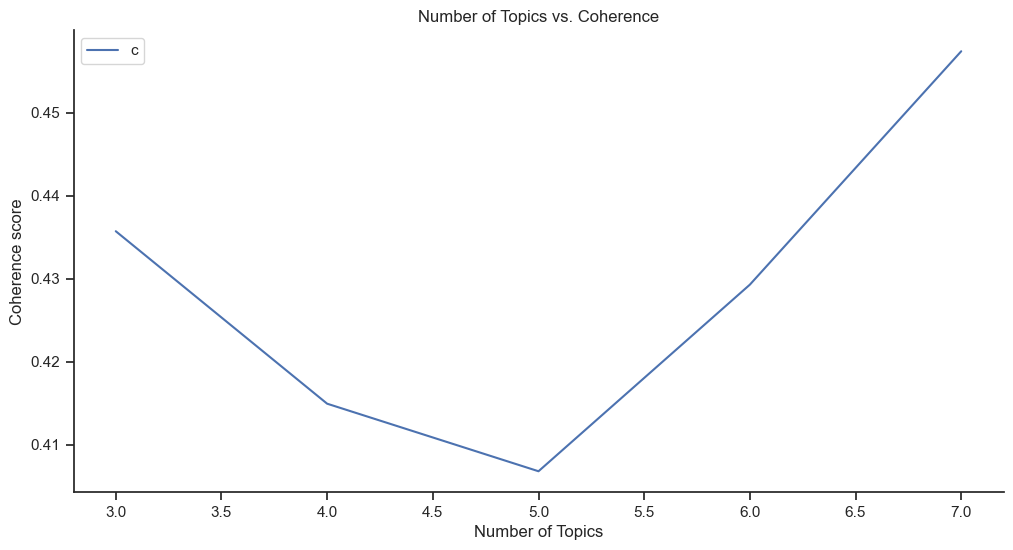

In [19]:
model_lda, coherence_df_lda = compute_coherence_values(tm = 'lda')

In [36]:
# Choosing the number of topics through the elbow technique.
# choose a point after which the diminishing increase of coherence score is no longer worth the additional increase of the number of topics. 
k = 6

## Hyperparameter tuning
Some explanation of the parameters that can be tuned: https://radimrehurek.com/gensim/models/ldamodel.html

* chunksize (int, optional) – Number of documents to be used in each training chunk.

* passes (int, optional) – Number of passes through the corpus during training.

* alpha ({float, numpy.ndarray of float, list of float, str}, optional) –

A-priori belief on document-topic distribution, this can be:
scalar for a symmetric prior over document-topic distribution,

1D array of length equal to num_topics to denote an asymmetric user defined prior for each topic.

Alternatively default prior selecting strategies can be employed by supplying a string:
’symmetric’: (default) Uses a fixed symmetric prior of 1.0 / num_topics,

’asymmetric’: Uses a fixed normalized asymmetric prior of 1.0 / (topic_index + sqrt(num_topics)).

* eta ({float, numpy.ndarray of float, list of float, str}, optional) –

A-priori belief on topic-word distribution, this can be:
scalar for a symmetric prior over topic-word distribution,

1D array of length equal to num_words to denote an asymmetric user defined prior for each word,

matrix of shape (num_topics, num_words) to assign a probability for each word-topic combination.

Alternatively default prior selecting strategies can be employed by supplying a string:
’symmetric’: (default) Uses a fixed symmetric prior of 1.0 / num_topics,

’auto’: Learns an asymmetric prior from the corpus.

* decay (float, optional) – A number between (0.5, 1] to weight what percentage of the previous lambda value is forgotten when each new document is examined. Corresponds to \kappa from ‘Online Learning for LDA’ by Hoffman et al.

* offset (float, optional) – Hyper-parameter that controls how much we will slow down the first steps the first few iterations. Corresponds to \tau_0 from ‘Online Learning for LDA’ by Hoffman et al.

* iterations (int, optional) – Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.

* gamma_threshold (float, optional) – Minimum change in the value of the gamma parameters to continue iterating.

* minimum_probability (float, optional) – Topics with a probability lower than this threshold will be filtered out.

In [21]:
from tqdm import tqdm

def coherence_value(doc_term_matrix, dictionary, corpus_tokenized, k, a, b, seed = seed):
    
    model = gensim.models.LdaMulticore(corpus = doc_term_matrix, id2word = dictionary, 
                                       num_topics = k, alpha = a, eta = b,
                                       passes = 20, 
                                       #iterations = 200, chunksize = 2000, 
                                       eval_every = None, random_state = seed)
    
    coherencemodel = CoherenceModel(model=model, texts=corpus_tokenized, dictionary=dictionary, coherence='c_v')
    
    return coherencemodel.get_coherence(), model, coherencemodel

# Topics range
#topics_range = range(3, 8, 1)

# Alpha parameter
alpha = list(np.linspace(0.01, 0.75, 3))
alpha.extend(['symmetric', 'asymmetric'])

# Beta parameter
beta = list(np.linspace(0.01, 0.75, 3))
beta.append('symmetric')

# Validation sets
#num_of_docs = len(doc_term_matrix)
#corpus_sets = [gensim.utils.ClippedCorpus(doc_term_matrix, int(num_of_docs*0.75)), doc_term_matrix]

#corpus_title = ['75% Corpus', '100% Corpus']

model_results = {#'Validation_Set': [],
    #'Topics': [],
    'alpha': [],
    'beta': [],
    'coherence': [],
    'model': [],
    'coherencemodel': [],
}
        
# Can take a long time to run
# iterate through validation corpuses
#for i in tqdm(range(len(corpus_sets)), desc = 'corpus_sets', position=0, leave=True):
# iterate through number of topics
#for k in tqdm(topics_range, desc = 'topics_range', position=1, leave=False):
# iterate through alpha values
for a in tqdm(alpha, desc = 'alpha', position=2, leave=False):
    # iterare through beta values
    for b in tqdm(beta, desc = 'beta', position=3, leave=False):
        # get the coherence score for the given parameters
        cv, model, coherencemodel = coherence_value(doc_term_matrix=doc_term_matrix, dictionary=dictionary, corpus_tokenized=corpus_ngram, k=k, a=a, b=b)
        # Save the model results
        #model_results['Validation_Set'].append(corpus_title[i])
        #model_results['Topics'].append(k)
        model_results['alpha'].append(a)
        model_results['beta'].append(b)
        model_results['coherence'].append(cv)
        model_results['model'].append(model)
        model_results['coherencemodel'].append(coherencemodel)


pd.DataFrame(model_results).to_csv('{}/lda_tuning_results.csv'.format(out_dir), index=False)
lda_tuning_results = pd.DataFrame(model_results).sort_values(by='coherence', ascending=False)
lda_tuning_results.head()



alpha:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]


beta:   0%|                                                                                      | 0/4 [00:00<?, ?it/s]


beta:  25%|███████████████████▌                                                          | 1/4 [01:07<03:21, 67.29s/it]


beta:  50%|███████████████████████████████████████                                       | 2/4 [02:14<02:14, 67.05s/it]


beta:  75%|██████████████████████████████████████████████████████████▌                   | 3/4 [03:21<01:06, 67.00s/it]


beta: 100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [04:28<00:00, 67.04s/it]


                                                                                                                       

alpha:  20%|███████████████▏                                                            | 1/5 [04:28<17:52, 268.23s/it]


beta:   0%|            

,alpha,beta,coherence,model,coherencemodel
2,0.01,0.75,0.48470,"LdaMulticore<num_terms=23892, num_topics=7, decay=0.5, chunksize=2000>","Coherence_Measure(seg=<function s_one_set at 0x000001DA61F4B5B0>, prob=<function p_boolean_slidi..."
14,symmetric,0.75,0.48423,"LdaMulticore<num_terms=23892, num_topics=7, decay=0.5, chunksize=2000>","Coherence_Measure(seg=<function s_one_set at 0x000001DA61F4B5B0>, prob=<function p_boolean_slidi..."
6,0.38,0.75,0.47375,"LdaMulticore<num_terms=23892, num_topics=7, decay=0.5, chunksize=2000>","Coherence_Measure(seg=<function s_one_set at 0x000001DA61F4B5B0>, prob=<function p_boolean_slidi..."
10,0.75,0.75,0.46298,"LdaMulticore<num_terms=23892, num_topics=7, decay=0.5, chunksize=2000>","Coherence_Measure(seg=<function s_one_set at 0x000001DA61F4B5B0>, prob=<function p_boolean_slidi..."
18,asymmetric,0.75,0.45408,"LdaMulticore<num_terms=23892, num_topics=7, decay=0.5, chunksize=2000>","Coherence_Measure(seg=<function s_one_set at 0x000001DA61F4B5B0>, prob=<function p_boolean_slidi..."


In [37]:
best_model = gensim.models.LdaMulticore(corpus = doc_term_matrix, id2word = dictionary, 
                                       num_topics = 6, alpha = lda_tuning_results['alpha'][0], eta = lda_tuning_results['beta'][0],
                                       passes = 20, iterations = 200, chunksize = 2000, eval_every = None,
                                       random_state = seed)

In [38]:
# Coherence per topic
topics = []
topics_raw = best_model.show_topics(num_words = num_words, formatted = False)
for k, content in topics_raw:
    topics.append(list(dict(content).keys()))

cm = CoherenceModel(topics=topics, texts=corpus_ngram, coherence='c_v',  dictionary=dictionary)

coherence_per_topic = cm.get_coherence_per_topic()

topics_str = [ ' '.join(t) for t in topics ]
data_topic_score = pd.DataFrame(data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Coherence'] )

data_topic_score

,Topic,Coherence
0,zacks stock investment research market security year nasdaq buy rank recommendation analyst perf...,0.63057
1,apple said aapl phone court case tax government data one time commission day back week,0.39892
2,apple year earnings stock quarter revenue billion share estimate growth phone market sale invest...,0.45311
3,apple said reuters tax inc china company technology year one new billion nasdaq state trump,0.33229
4,apple percent nasdaq stock share market year nyse index said phone inc week china dow,0.41907
5,apple phone service new analyst year nasdaq market sale streaming price zacks music device share,0.38796


## Deployment & Analysis
Sometimes, words that are ranked as top words for a given topic may be ranked high because they are globally frequent across text in a corpus. Relevancy score helps to prioritize terms that belong more exclusively to a given topic. This can increase interpretability even more. The relevance of term w to topic k is defined as:

r(w,k|λ)=λlog(ϕkw)+(1−λ)log(ϕkwpkw) 
where  ϕkw  is the probability of term w in topic k and  ϕkwpkw  is lift in term's probability within a topic to its marginal probability across the corpus (this helps discards globally frequent terms). A lower lambda value gives more importance to the second term, which gives more importance to topic exclusivity. We can use Python’s pyLDAvis for this. For example, when lowering lambda, we can see that topic 0 ranked terms that are even more relevant to the topic of hair salon service the highest.

Paper behind this tool: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(best_model, doc_term_matrix, dictionary)

with open('{}/ldavis.csv'.format(out_dir), 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open('{}/ldavis.csv'.format(out_dir), 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, '{}/ldavis'.format(out_dir) + '.html')

pyLDAvis.display(LDAvis_prepared)

D:\Users\camil\anaconda3\envs\pytorch_venv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [40]:
def format_topics_sentences(model, dictionary = dictionary, doc_term_matrix = doc_term_matrix, corpus = corpus):
    """
    Input   : ldamodel : Gensim generated LDA model
            cleaned_text : preprocessed text
    purpose : Find the most dominant topic in each document and its percentage contribution
    Output  : Dataframe displaying the  most dominant topic in each document and its percentage contribution
    """
    sent_topics_df = pd.DataFrame()

    #Get main topic in each document
    for i, row_list in enumerate(model[doc_term_matrix]):
        row = row_list[0] if model.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        #content = data.iloc[i]['content']
        #Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, contrib) in enumerate(row):
            if j == 0:  # => dominant topic
                #wp = model.show_topic(topic_num)
                #topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df,
                                            pd.DataFrame({'Dominant_Topic': [int(topic_num)],
                                                          'Perc_Contribution' : [round(contrib,4)],
                                                          #'content' : [content]
                                                         })],
                                           ignore_index=True, axis=0)

            else:
                break

    #sent_topics_df.

    #Add original text to the end of the output
    sent_topics_df = pd.concat([sent_topics_df, data['content'].reset_index(drop = True)], ignore_index=True, axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'content']

    return sent_topics_df

sent_topics_df=[]
sent_topics_df = format_topics_sentences(best_model)
sent_topics_df

,Dominant_Topic,Perc_Contribution,content
0,4,0.9998,Investing com A rout in Apple and Facebook NASDAQ FB Monday swept through tech prompting a ...
1,5,0.4830,For Immediate ReleaseChicago IL January 9 2020 Shares of Tempur Sealy NYSE TPX as the...
2,0,0.7358,For Immediate ReleaseChicago IL December 30 2019 Zacks com announces the list of stocks fe...
3,5,0.6516,For Immediate ReleaseChicago IL December 18 2019 Zacks com announces the list of stocks fe...
4,0,0.4511,For Immediate ReleaseChicago IL November 26 2019 NVIDIA NASDAQ NVDA as the Bull of th...
...,...,...,...
2904,4,0.9998,Investing com U S stock markets were mixed to lower after the open on Wednesday as markets l...
2905,4,0.9866,Investing com U S stocks were mixed after the open on Tuesday as market sentiment was weighe...
2906,4,0.8641,President Obama addressed the US people on Tuesday night and confirmed that he was planning to p...
2907,4,0.6170,Apple Nasdaq AAPL kicks off another eagerly anticipated Worldwide Developers Conference today...


In [41]:
def most_repr_sent_tp(sent_topics_df):

    """
    Input   : ldamodel : Dataframe containing the most dominant topic and its contribution per document
    purpose : Find the most representative sentence for each topic
    Output  : Dataframe displaying the most representative sentence for each topic
    """

    sent_topics_sorted_df = pd.DataFrame()

    grouped_document_dom_topic_df = sent_topics_df.groupby('Dominant_Topic')

    for i, grp in grouped_document_dom_topic_df:
        sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)

    sent_topics_sorted_df.reset_index(drop=True, inplace=True)

    sent_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Representative Text"]

    return sent_topics_sorted_df

final_df = pd.concat([data_topic_score,most_repr_sent_tp(sent_topics_df)['Representative Text']], axis = 1)
final_df

In [43]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', 500):
    print(final_df)

                                                                                                                           Topic  \
0  zacks stock investment research market security year nasdaq buy rank recommendation analyst performance portfolio information   
1                                         apple said aapl phone court case tax government data one time commission day back week   
2                      apple year earnings stock quarter revenue billion share estimate growth phone market sale investor nasdaq   
3                                    apple said reuters tax inc china company technology year one new billion nasdaq state trump   
4                                          apple percent nasdaq stock share market year nyse index said phone inc week china dow   
5                               apple phone service new analyst year nasdaq market sale streaming price zacks music device share   

   Coherence  \
0    0.63057   
1    0.39892   
2    0.45311   
3    0.3322

## Sources
* LDA: https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2
    * https://highdemandskills.com/topic-modeling-intuitive/
* ngrams, Hyperparameter Tuning: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
* How topic coherence works: https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c
    * https://www.baeldung.com/cs/topic-modeling-coherence-score
* NMF: https://github.com/robsalgado/personal_data_science_projects
    * https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
* Limitations: https://medium.com/analytics-vidhya/latent-dirichelt-allocation-1ec8729589d4
* In general, what procedures: https://monkeylearn.com/text-analysis/
    * https://nicharuc.github.io/topic_modeling/
    * https://github.com/JoanneBurke/NLP-Projects
    * https://towardsdatascience.com/sentiment-analysis-a-deep-dive-into-the-theory-methods-and-applications-322f984f2b48

Michael Röder, Andreas Both, and Alexander Hinneburg. 2015. Exploring the Space of Topic Coherence Measures. In Proceedings of the Eighth ACM International Conference on Web Search and Data Mining (WSDM '15). Association for Computing Machinery, New York, NY, USA, 399–408. https://doi.org/10.1145/2684822.2685324